#3D Object Detection with 3D Transformations
---------------------------
By : Juan C. Peña and Eberto Benjumea

**(Pending documentation)**

------------------------------------
# Installing dependences

In [1]:
#@title
%%capture
!pip install deeptrack

In [2]:
#@title
%%capture
!pip install geopandas

In [3]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#@title
import os
import cv2
import random
import scipy.io
%matplotlib inline
import numpy as np
import deeptrack as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage import img_as_float
from shapely.geometry import Point
from matplotlib.patches import Rectangle
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
#@title
class Preprocessor():

  def __init__(self,
               scales=[1, 2, 4]
               ):
    self.scales = scales


  def crop(self, image, x, y, wide):
    cropped_image = image[y: y + wide, x: x + wide]

    return cropped_image

  def normalizate(self, image):
    normalized_image = np.nan_to_num(image)
    normalized_image = (normalized_image - np.quantile(normalized_image, 0.01)) / (np.quantile(normalized_image, 0.99) - np.quantile(normalized_image, 0.01))

    return normalized_image


  def resize(self, image, scale):
    resized_image = cv2.resize(image, (0, 0), fx=1/scale, fy=1/scale)

    return resized_image

  def generate_pipeline(self, data, transformations):
    pipeline = None
    for transformation in transformations:
        if pipeline is None:
            pipeline = transformation
        else:
            pipeline = pipeline >> transformation

    return pipeline

  def create_train_data(self, data, transformations):
    # data -> an image o a list of images
    normalized_images = [self.normalizate(image) for image in data]
    training_images = [np.expand_dims(image, axis = -1) for image in normalized_images]

    pipeline = self.generate_pipeline(training_images, transformations)
    train_set = dt.Value(lambda: np.array(random.choice(training_images))) >> pipeline
    train_set.plot()

    return train_set

  def load_images(self, data, plot=True):
    original_image = self.normalizate(data)
    input_set = [self.resize(original_image, scale) for scale in self.scales]

    if plot:
      fig, ax = plt.subplots(1, len(input_set), figsize=(25,5))
      fig.tight_layout()
      fig.suptitle('Scaled 3D images')
      for index in range(len(input_set)):
        ax[index].imshow(input_set[index])

    return input_set

# --------------------------------------------------------------------
class Trainer():

  def __init__(self,
               filepath,
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               callbacks = [None]
               ):

    self.model = model
    self.filepath = filepath
    self.callbacks = [
        ModelCheckpoint(filepath=self.filepath,
                        save_weights_only=True,
                        monitor='consistency_loss',
                        mode='min',
                        save_best_only=True
                        ),
        EarlyStopping(monitor="total_loss",
                      patience=15,
                      verbose=1,
                      mode="auto",
                      restore_best_weights=True
                      ),
        LearningRateScheduler(lambda epoch, lr: lr if epoch < 10 else lr * np.exp(-0.1))
    ]

  def fit(self, train_set, epochs=40, batch_size=8):
    history = self.model.fit(
        train_set,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = self.callbacks)

    return history

  def plot_performance(self, history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    fig.suptitle('Total loss and consistency loss')

    ax1.plot(history.history['total_loss'])
    ax1.set_title('Total loss')
    ax1.set(xlabel='epoch', ylabel='loss')
    ax1.set_ylim([0, 1.5])

    ax2.plot(history.history['consistency_loss'])
    ax2.set_title('Consitency loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.set_ylim([0, 1.5])

    plt.show()

# --------------------------------------------------------------------
class Detector():

  def __init__(self,
               downsample,
               alpha = 0.1,
               cutoff = 0.998,
               mode = "quantile",
               colors = 'rgb',
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               ):
    self.downsample = downsample
    self.alpha = alpha
    self.cutoff = cutoff
    self.mode = mode
    self.colors = colors
    self.model = model

  def detect(self, image, plot=True):
    test_set = image[np.newaxis, :, :, np.newaxis]
    test_image = test_set[:, ::self.downsample, ::self.downsample, :]

    detections = self.model.predict_and_detect(test_image, alpha=self.alpha, beta=1-self.alpha, cutoff=self.cutoff, mode=self.mode)[0]
    detections[:, 1] = detections[:, 1] * self.downsample
    detections[:, 0] = detections[:, 0] * self.downsample

    return detections

  def detect_all(self, images, plot=False):
    detections = []

    if plot:
      fig, ax = plt.subplots(1, len(images), figsize=(25, 5))
      fig.tight_layout()
      fig.suptitle('Detections')

    for index in range(len(images)):
      det = self.detect(image=images[index])
      detections.append(det)

      if plot:
        ax[index].imshow(images[index])
        ax[index].scatter(detections[index][:, 1], detections[index][:, 0], color=self.colors[index])

    return detections

# --------------------------------------------------------------------
class Postprocessor():

  def __init__(self,
               wide=50,
               scales=[1, 2, 4],
               colors = 'rgb'
               ):
    self.wide = wide
    self.scales = scales
    self.colors = colors

  def scale_detections(self, detection, scale):
    scaled_detection = detection * scale

    return scaled_detection.tolist()

  def create_boxes(self, detections):
    list_detections = [Point((x,y)) for (y,x) in detections]
    points = gpd.GeoSeries(list_detections)
    boxes = points.buffer(self.wide, cap_style = 3)
    bounds = np.array([boxes[index].bounds for index in range(len(boxes))])

    return boxes, bounds

  def NMSupression(self, boxes, overlapThresh):
    # Malisiewicz et al. - non_max_suppression_fast
    if len(boxes) == 0:
      return []

    if boxes.dtype.kind == "i":
      boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
      last = len(idxs) - 1
      i = idxs[last]
      pick.append(i)

      xx1 = np.maximum(x1[i], x1[idxs[:last]])
      yy1 = np.maximum(y1[i], y1[idxs[:last]])
      xx2 = np.minimum(x2[i], x2[idxs[:last]])
      yy2 = np.minimum(y2[i], y2[idxs[:last]])

      w = np.maximum(0, xx2 - xx1 + 1)
      h = np.maximum(0, yy2 - yy1 + 1)

      overlap = (w * h) / area[idxs[:last]]

      idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

  def apply_nms(self, image, list_bounds, figsize = (15,15), overlapThresh=0.3):
    all_bounds = [bounds.tolist() for bounds in list_bounds]
    final_bounds = []

    for index in range(len(all_bounds)):
      final_bounds += all_bounds[index]

    final_bounds = np.array(final_bounds)
    final_detections = self.NMSupression(final_bounds,
                                         overlapThresh=overlapThresh)
    self.plot_results(image, final_detections, figsize)

    return final_detections


  def plot_boxes(self, test_image, detections, figsize=(15, 15), plot=True):
    list_boxes, list_bounds, scaled_detections = [], [], []

    if plot:
      fig, ax = plt.subplots(figsize=figsize)
      plt.imshow(test_image)

    for index in range(len(detections)):
      scaled_det = self.scale_detections(detections[index], self.scales[index])
      scaled_detections.append(scaled_det)

      boxes, bounds = self.create_boxes(scaled_detections[index])
      list_boxes.append(boxes)
      list_bounds.append(bounds)

      if plot:
        boxes.boundary.plot(ax=ax, color = self.colors[index])

    return list_bounds

  def plot_results(self, image, boxes, figsize, color='red', lw=2):
    plt.figure(figsize=figsize)
    plt.imshow(image)

    wide = self.wide * 2
    for i in range(len(boxes)):
      rect = Rectangle((boxes[i][0], boxes[i][1]),wide,wide,
                       edgecolor=color,
                       facecolor='none',
                       lw=lw)

      plt.gca().add_patch(rect)

------------------------------------
# Settings

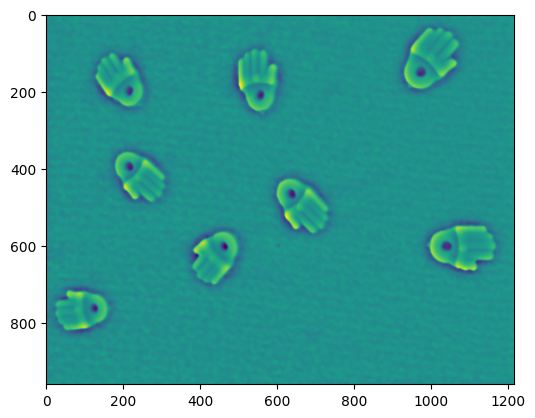

In [6]:
#@title
train_data = scipy.io.loadmat('/content/drive/MyDrive/Investigacion/Data/MATLAB/Recortados/reconstruction00.mat')
Spz, XcM, YcM = train_data['Spz'], train_data['XcM'], train_data['YcM']
plt.imshow(Spz)

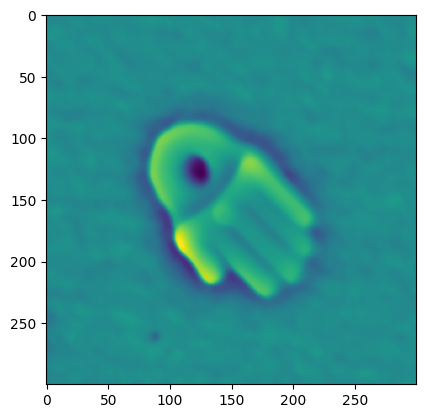

In [7]:
preprocessor = Preprocessor()
x, y, crop_size = (515, 340, 300)
Zcrop = preprocessor.crop(Spz, x, y, crop_size)
plt.imshow(Zcrop)

------------------------------------
# 3D Transformations
### We are applying 3D rotations and x, y and z translations

In [8]:
#@title
# Generate the transformation matrix
def generate_transformation_matrix(ax, ay, az, tx, ty, tz):
    ax = ax * np.pi / 180
    ay = ay * np.pi / 180
    az = az * np.pi / 180

    Rrec = np.array([
        [np.cos(ay) * np.cos(az), np.sin(ax) * np.sin(ay) * np.cos(az) - np.cos(ax) * np.sin(az),
         np.cos(ax) * np.sin(ay) * np.cos(az) + np.sin(ax) * np.sin(az)],
        [np.cos(ay) * np.sin(az), np.sin(ax) * np.sin(ay) * np.sin(az) + np.cos(ax) * np.cos(az),
         np.cos(ax) * np.sin(ay) * np.sin(az) - np.sin(ax) * np.cos(az)],
        [-np.sin(ay), np.sin(ax) * np.cos(ay), np.cos(ax) * np.cos(ay)]
    ])

    Mext_rec = np.eye(4)
    Mext_rec[:3, :3] = Rrec
    Mext_rec[0, 3] = tx
    Mext_rec[1, 3] = ty
    Mext_rec[2, 3] = tz

    return Mext_rec

# Transform the points using the transformation matrix
def transform_points(Mext_rec, Xcrop, Ycrop, Zcrop):
    P = np.stack((Xcrop.flatten(), Ycrop.flatten(), Zcrop.flatten(), np.ones_like(Xcrop.flatten())))
    P_rot = Mext_rec @ P

    return P, P_rot[:3, :]

# Generate a random transformation within the specified ranges
def generate_random_transformation(transformation_ranges):
    ax = np.random.uniform(transformation_ranges['ax'][0], transformation_ranges['ax'][1])
    ay = np.random.uniform(transformation_ranges['ay'][0], transformation_ranges['ay'][1])
    az = np.random.uniform(transformation_ranges['az'][0], transformation_ranges['az'][1])
    tx = np.random.uniform(transformation_ranges['tx'][0], transformation_ranges['tx'][1])
    ty = np.random.uniform(transformation_ranges['ty'][0], transformation_ranges['ty'][1])
    tz = np.random.uniform(transformation_ranges['tz'][0], transformation_ranges['tz'][1])

    return generate_transformation_matrix(ax, ay, az, tx, ty, tz)


def generate_transformed_images(images, transformation_ranges, num_images, num_cols=5, plot=True):
    transformed_images = []

    for _ in range(num_images):
        # Generate a random transformation
        Mext_rec = generate_random_transformation(transformation_ranges)

        if isinstance(images, list):
            # Transform each image in the list
            transformed_image_list = []
            for image_to_transform in images:
                # Transform the image using the generated transformation matrix
                P, P_rot_3D = transform_points(Mext_rec, XcM, YcM, image_to_transform)
                transformed_image = P_rot_3D[2, :].reshape(Spz.shape)
                transformed_image_list.append(transformed_image)

            transformed_images.append(transformed_image_list)
        else:
            # Transform the single image
            P, P_rot_3D = transform_points(Mext_rec, XcM, YcM, images)
            transformed_image = P_rot_3D[2, :].reshape(Spz.shape)
            transformed_images.append(transformed_image)

    if plot:
        num_rows = int(np.ceil(num_images / num_cols))
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
        axes = axes.flatten()

        for i, transformed_image in enumerate(transformed_images):
            axes[i].imshow(transformed_image)
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    return transformed_images


def generate_transformed_crops(image_to_transform, crop_coords, transformation_ranges, N, num_cols=5, plot=True):
    preprocessor = Preprocessor()
    transformed_crops = []

    # Obtain the original crop
    original_crop = preprocessor.crop(image_to_transform, *crop_coords)

    # Append the original crop to the transformed crops list
    transformed_crops.append(original_crop)

    # N-1 to save also the original crop
    for _ in range(N-1):
        # Generate a random transformation
        Mext_rec = generate_random_transformation(transformation_ranges)

        # Transform the image using the generated transformation matrix
        P, P_rot_3D = transform_points(Mext_rec, XcM, YcM, image_to_transform)
        transformed_image = P_rot_3D[2, :].reshape(Spz.shape)

        # Translate the crop coordinates
        x, y, crop_size = crop_coords
        translated_x = int(x + Mext_rec[0, 3])
        translated_y = int(y + Mext_rec[1, 3])
        translated_crop_coords = (translated_x, translated_y, crop_size)

        # Crop the transformed image
        transformed_crop = preprocessor.crop(transformed_image, *translated_crop_coords)

        # Append the transformed crop to the list of transformed crops
        transformed_crops.append(transformed_crop)

    if plot:
        num_rows = int(np.ceil(N / num_cols))
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
        for i, ax in enumerate(axes.flatten()):
            if i < N:
                ax.imshow(transformed_crops[i])
                ax.axis('off')

        plt.tight_layout()
        plt.show()

    return transformed_crops

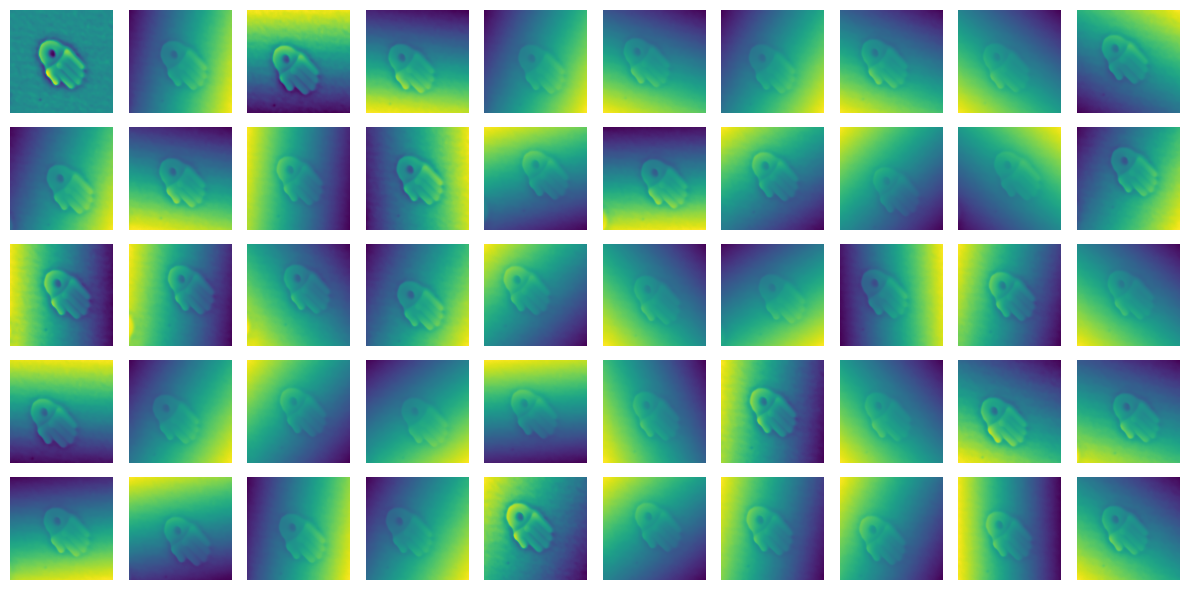

In [9]:
# Set the image, crop coordinates, and transformation ranges
n_crops = 50
image_to_crop = Spz
crop_coords = (x, y, crop_size)
crop_transf_ranges = {'ax': (-5, 5), 'ay': (-5, 5), 'az': (-5, 5), 'tx': (-30, 30), 'ty': (-30, 30), 'tz': (-30, 30)}

# Generate and display the transformed crops
transformed_crops = generate_transformed_crops(image_to_crop, crop_coords, crop_transf_ranges, n_crops, num_cols=10, plot=True)

------------------

# Model Training

In [10]:
size_object = 300 # 100
wide = 60 # size of the training template -> max=20
downsample = size_object // wide

### Some 2D transformations

In [11]:
transformations = (
    #Add:  dt.ElasticTransformation
    dt.Affine(translate=lambda:np.random.uniform(-1.5, 1.5, 2), rotate=lambda: np.random.rand()*np.pi*2),
    dt.AveragePooling(ksize=(downsample, downsample, 1)),
    dt.Add(lambda: np.random.randn() * 0.1),
    dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01)), # Very sensitive
    dt.Multiply(lambda: np.random.uniform(0.6, 1.2)) # 0.3, 1.6
)

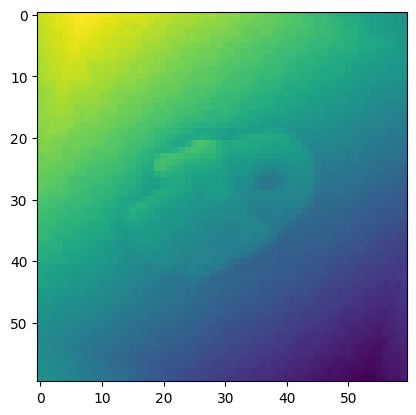

In [12]:
train_set = preprocessor.create_train_data(transformed_crops, transformations)

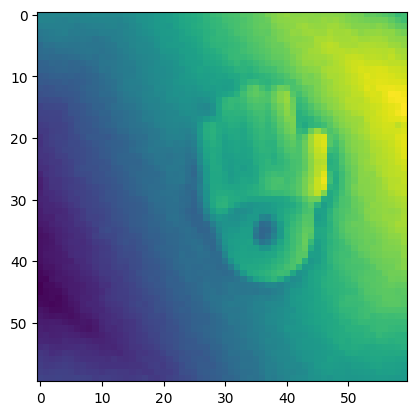

In [13]:
image = train_set.update()()
plt.imshow(image)

In [14]:
filepath = '/content/drive/MyDrive/Investigacion/Model/checkpoints/domino_3D_transformations'
trainer = Trainer(filepath)

In [15]:
history = trainer.fit(train_set, epochs=50)

Generating 165 / 160 samples before starting training
Epoch 1/50
165/165 [==============================] - 18s 23ms/step - total_loss: 3.6905 - consistency_loss: 1.9960 - lr: 0.0010
Epoch 2/50
165/165 [==============================] - 5s 30ms/step - total_loss: 3.1182 - consistency_loss: 1.5575 - lr: 0.0010        
Epoch 3/50
165/165 [==============================] - 6s 36ms/step - total_loss: 2.6228 - consistency_loss: 1.2651 - lr: 0.0010              
Epoch 4/50
165/165 [==============================] - 7s 45ms/step - total_loss: 2.5286 - consistency_loss: 1.1569 - lr: 0.0010                   
Epoch 5/50
165/165 [==============================] - 5s 33ms/step - total_loss: 2.3652 - consistency_loss: 1.0122 - lr: 0.0010                        
Epoch 6/50
165/165 [==============================] - 7s 40ms/step - total_loss: 2.3004 - consistency_loss: 0.9734 - lr: 0.0010                         
Epoch 7/50
165/165 [==============================] - 8s 50ms/step - total_loss: 2.3909

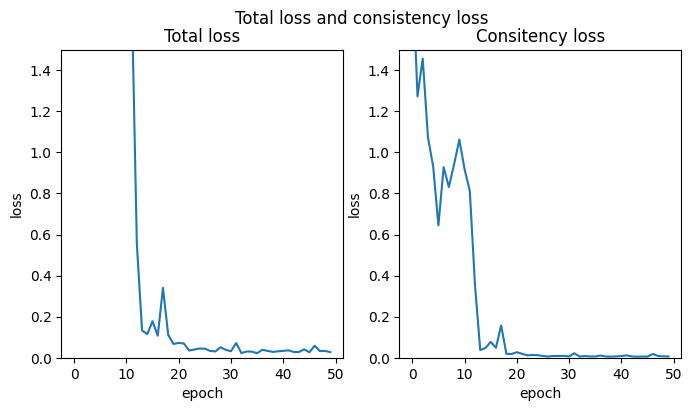

In [16]:
trainer.plot_performance(history)

# Testing with 3D untransformed images

In [17]:
filepath = '/content/drive/MyDrive/Investigacion/Model/checkpoints/domino_3D_transformations'
trainer = Trainer(filepath)
trainer.model = dt.models.LodeSTAR(input_shape=(None, None, 1))
trainer.model.load_weights(filepath)

In [18]:
def get_file_names(folder_path):
    file_names = []
    for file_name in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file_name)):
            file_names.append(file_name)
    return file_names

In [19]:
#@title
def test(test_data, model, downsample=1, alpha=0.1, cutoff=0.99, mode="quantile", plotPrevious=True):
  preprocessor = Preprocessor()
  input_set = preprocessor.load_images(test_data, plot=plotPrevious)
  detector = Detector(downsample, model=model, alpha=alpha, cutoff=cutoff, mode=mode)
  detections = detector.detect_all(input_set, plot=plotPrevious)
  postprocessor = Postprocessor()
  test_image = input_set[0]
  bounds = postprocessor.plot_boxes(test_image, detections, plot=plotPrevious)
  final_detections = postprocessor.apply_nms(test_image, bounds, figsize = (8,8))

  return final_detections

## b. Without surface remotion

In [20]:
path_with_surface = '/content/drive/MyDrive/Investigacion/Data/MATLAB/Recortados/'
file_names_2 = get_file_names(path_with_surface)

withSurface_test_set = []
for reconstruction in file_names_2:
  image = scipy.io.loadmat(f'{path_with_surface}{reconstruction}')
  try:
    withSurface_test_set.append(image['ZcM_r'])
  except:
    withSurface_test_set.append(image['Spz'])

1/1 [==============================] - 0s 29ms/step


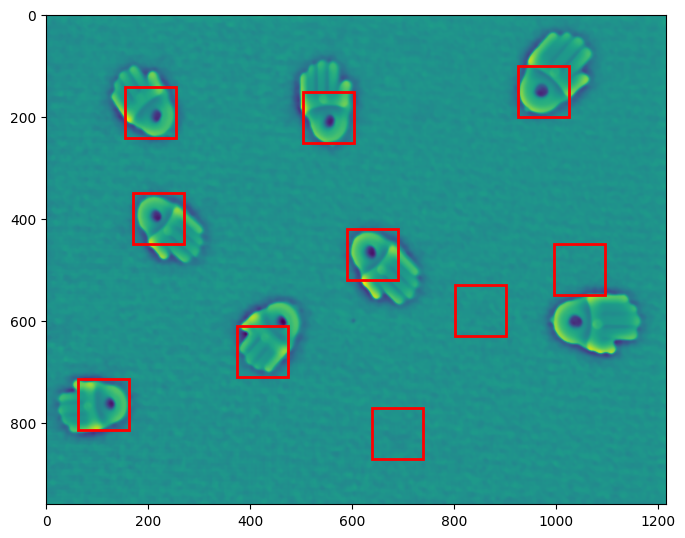

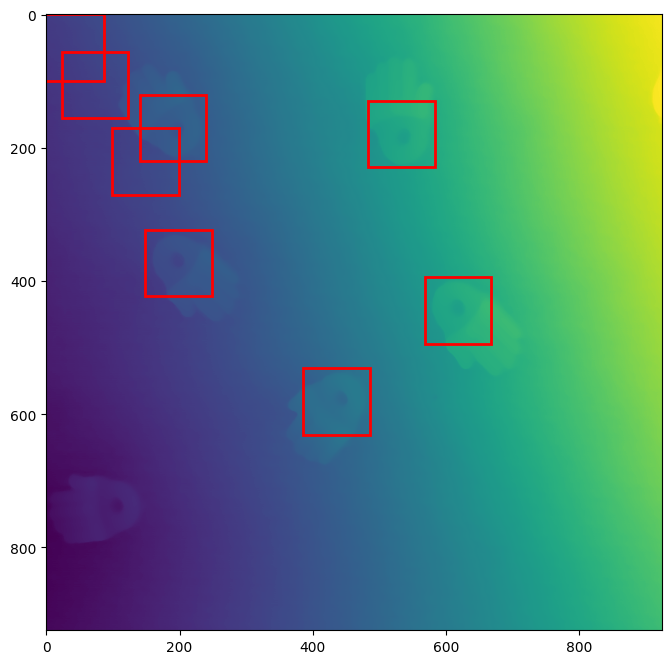

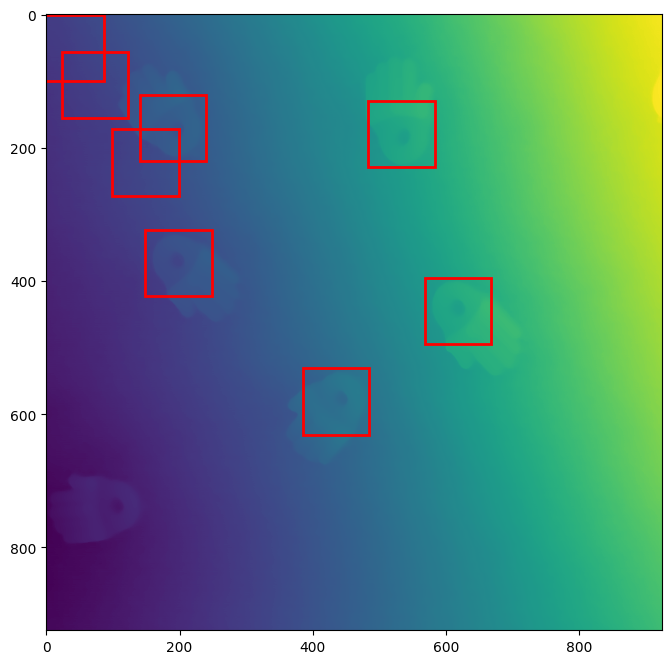

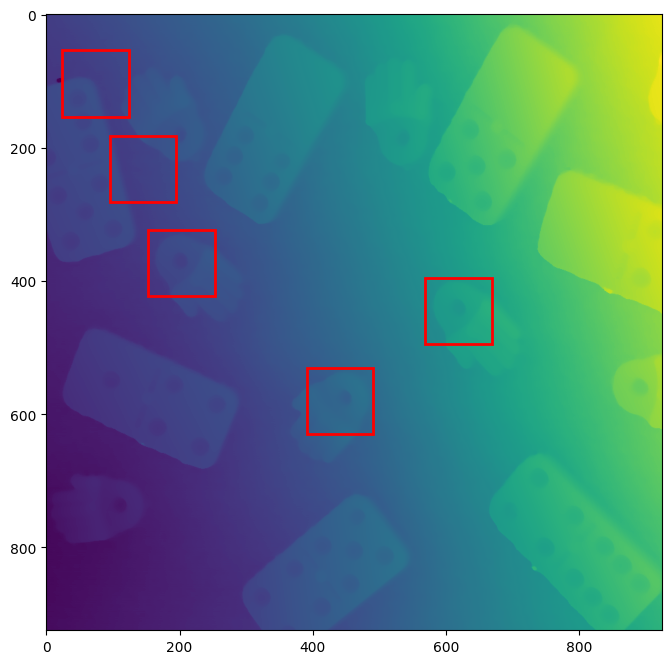

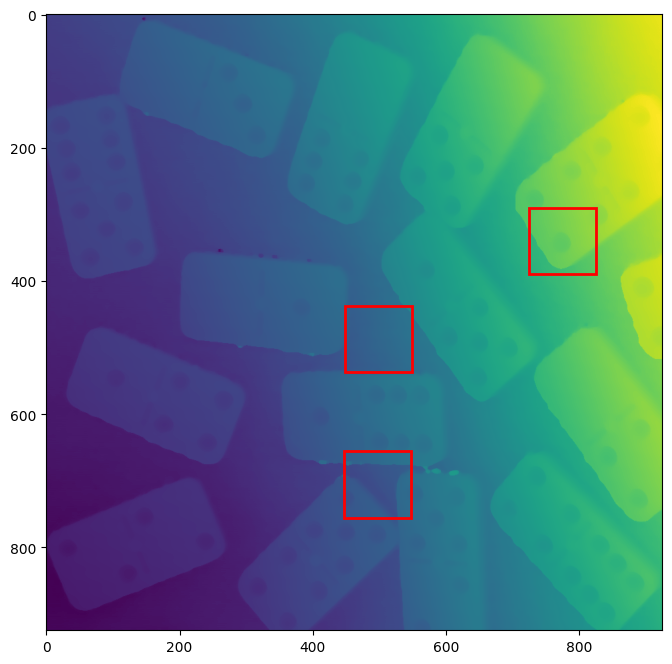

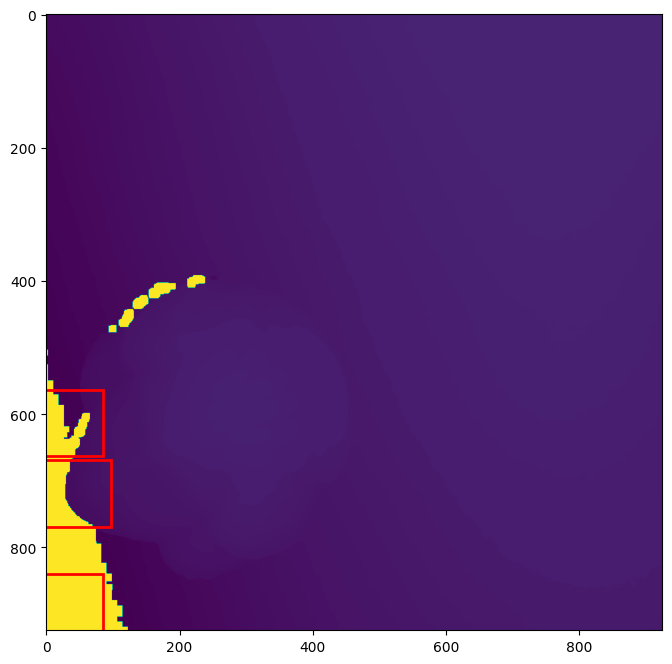

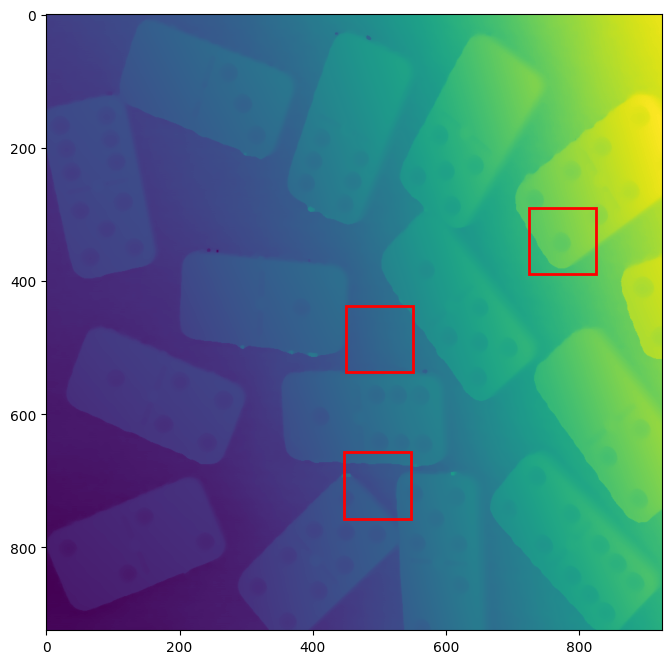

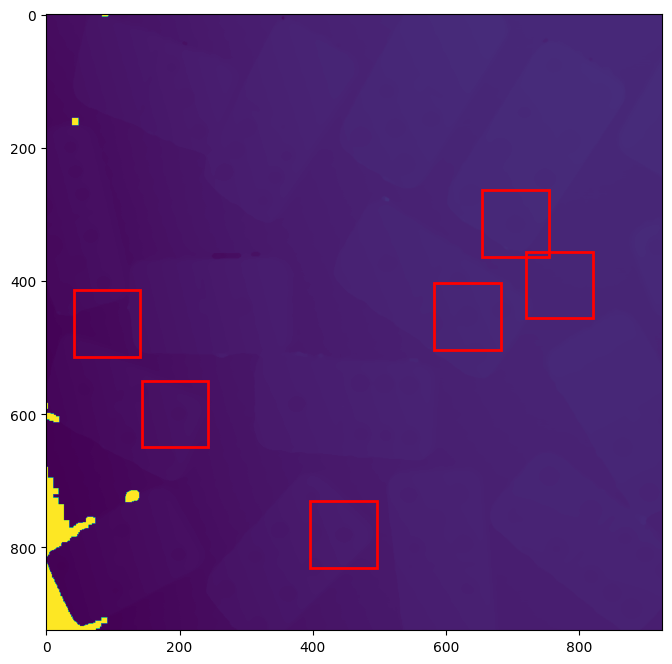

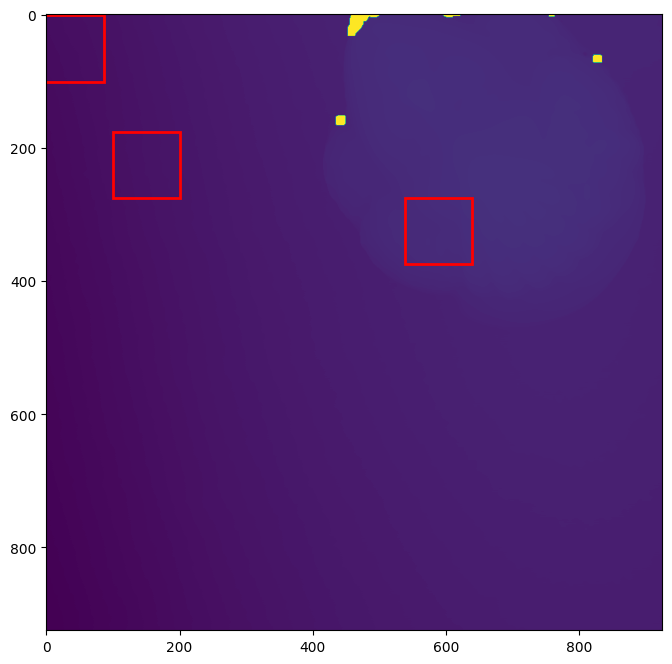

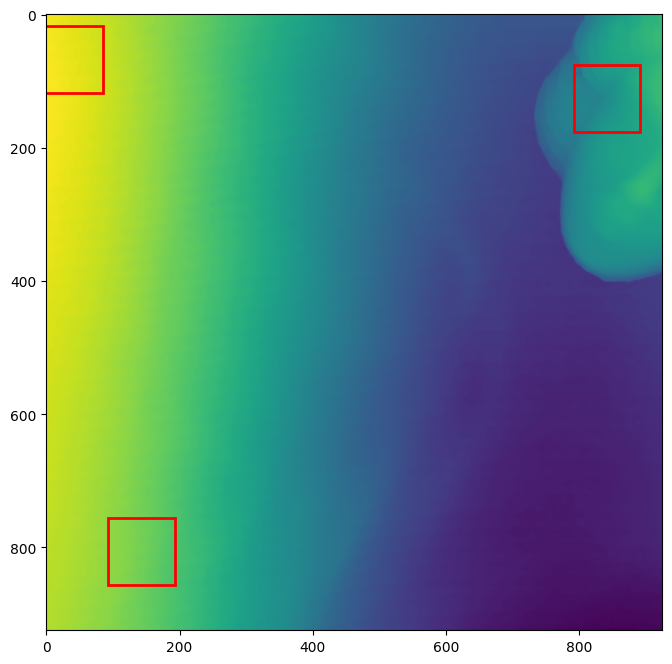

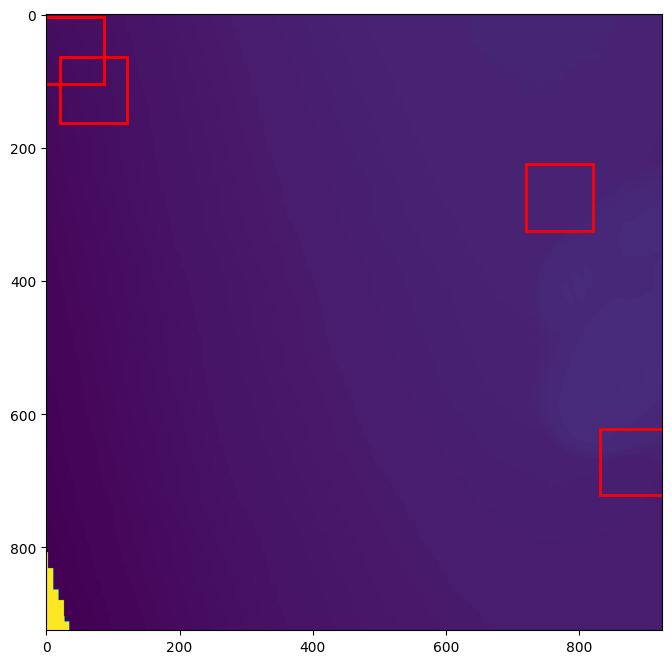

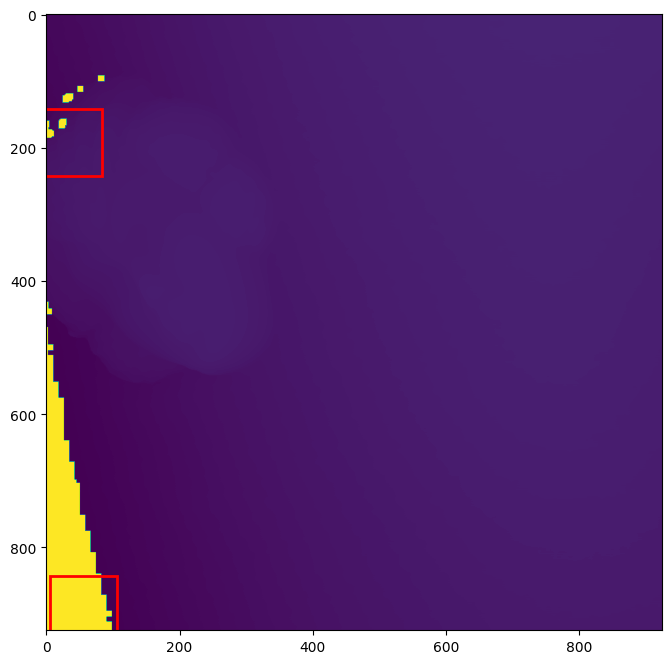

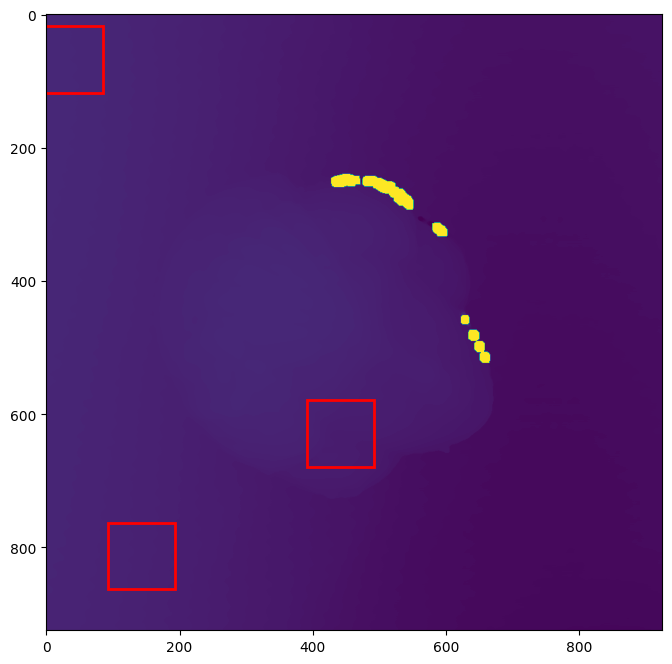

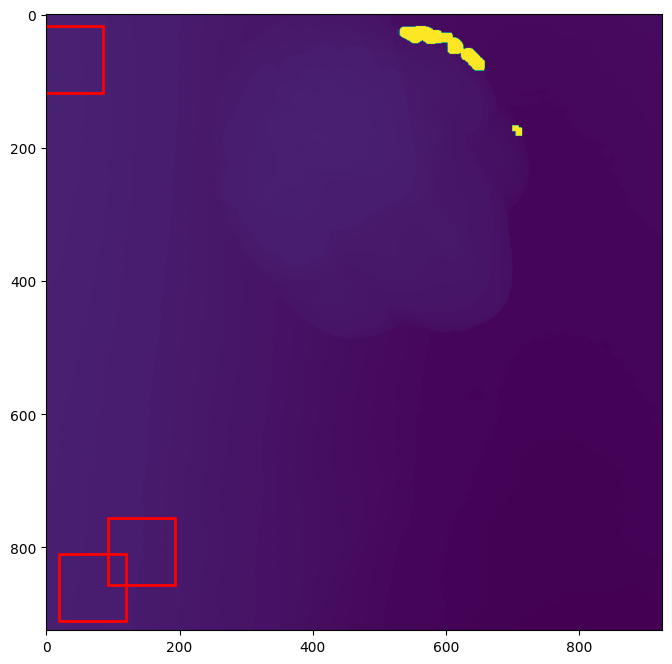

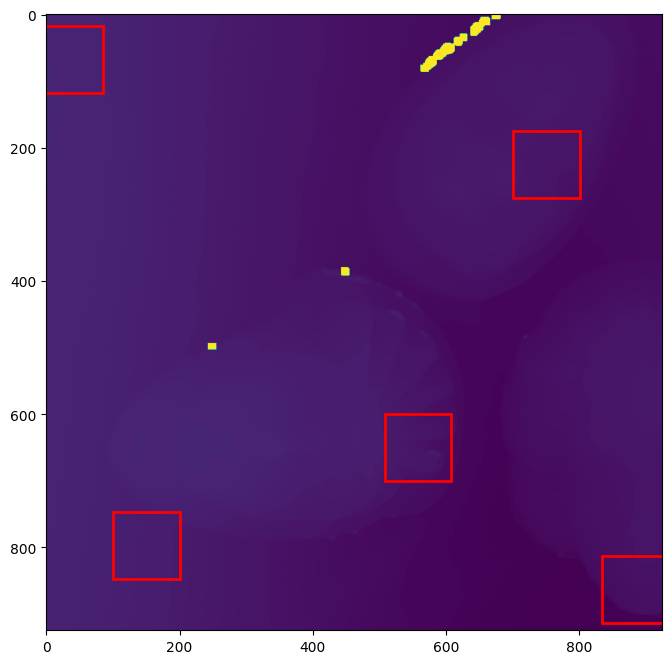

In [55]:
# Detection settings
cutoff = 0.9988
alpha = 1 - cutoff
mode = "quantile"

for idx in range(len(withSurface_test_set)):
  final_detections = test(withSurface_test_set[idx], trainer.model, downsample=downsample, alpha=alpha, cutoff=cutoff, plotPrevious=False)